### This script will filter, then make logo plots for each mAb against NiV

In [1]:
# this cell is tagged as parameters for `papermill` parameterization
nipah_config = None

HENV103_file = None
HENV117_file = None
HENV26_file = None
HENV32_file = None
m102_file = None
nAH1_file = None

HENV103_filtered_path = None
HENV117_filtered_path = None
HENV26_filtered_path = None 
HENV32_filtered_path = None 
m102_filtered_path = None
nAH1_filtered_path = None

HENV103_logo_path = None
HENV117_logo_path = None
HENV26_logo_path = None
HENV32_logo_path = None
m102_logo_path = None
nAH1_logo_path = None

In [2]:
import math
import os
import re

import altair as alt

import numpy as np

import pandas as pd

import scipy.stats

import Bio.SeqIO
import yaml
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'

from Bio import PDB
import dmslogo
from dmslogo.colorschemes import CBPALETTE
from dmslogo.colorschemes import ValueToColorMap

In [3]:
# allow more rows for Altair
_ = alt.data_transformers.disable_max_rows()

if os.getcwd() == '/fh/fast/bloom_j/computational_notebooks/blarsen/2023/Nipah_Malaysia_RBP_DMS/':
    pass
    print("Already in correct directory")
else:
    os.chdir("/fh/fast/bloom_j/computational_notebooks/blarsen/2023/Nipah_Malaysia_RBP_DMS/")
    print("Setup in correct directory")

Setup in correct directory


# Make logo plots

In [4]:
if HENV103_logo_path is None:
    nipah_config = 'nipah_config.yaml'

    HENV103_file = 'results/antibody_escape/averages/HENV103_mut_effect.csv'
    HENV117_file = 'results/antibody_escape/averages/HENV117_mut_effect.csv'
    HENV26_file = 'results/antibody_escape/averages/HENV26_mut_effect.csv'
    HENV32_file = 'results/antibody_escape/averages/HENV32_mut_effect.csv'
    m102_file = 'results/antibody_escape/averages/m102.4_mut_effect.csv'
    nAH1_file = 'results/antibody_escape/averages/nAH1.3_mut_effect.csv'
    
    HENV103_filtered_path = 'results/filtered_data/HENV103_escape_filtered.csv'
    HENV117_filtered_path = 'results/filtered_data/HENV117_escape_filtered.csv'
    HENV26_filtered_path = 'results/filtered_data/HENV26_escape_filtered.csv'
    HENV32_filtered_path = 'results/filtered_data/HENV32_escape_filtered.csv'
    m102_filtered_path = 'results/filtered_data/m102_escape_filtered.csv'
    nAH1_filtered_path = 'results/filtered_data/nAH1_escape_filtered.csv'
    
    HENV103_logo_path = 'results/images/logo_plots/HENV103_logo.svg'
    HENV117_logo_path = 'results/images/logo_plots/HENV117_logo.svg'
    HENV26_logo_path = 'results/images/logo_plots/HENV26_logo.svg'
    HENV32_logo_path = 'results/images/logo_plots/HENV32_logo.svg'
    m102_logo_path = 'results/images/logo_plots/m102_logo.svg'
    nAH1_logo_path = 'results/images/logo_plots/nAH1_logo.svg'

In [5]:
with open(nipah_config) as f:
    config = yaml.safe_load(f)

In [6]:
HENV103 = pd.read_csv(HENV103_file)
HENV117 = pd.read_csv(HENV117_file)
HENV26 = pd.read_csv(HENV26_file)
HENV32 = pd.read_csv(HENV32_file)
m102 = pd.read_csv(m102_file)
nAH1 = pd.read_csv(nAH1_file)

### Make escape logo plots colored by entry score

[147, 205, 235, 258, 259, 260, 264, 370]

[258, 351, 555, 580, 582, 583, 586, 587]

[490, 491, 492, 494, 497, 501, 529, 530]

[154, 176, 199, 200, 205, 207, 268, 534]

[239, 507, 559, 577, 582, 586, 587, 589]

[185, 188, 447, 450, 452, 468, 517, 518]

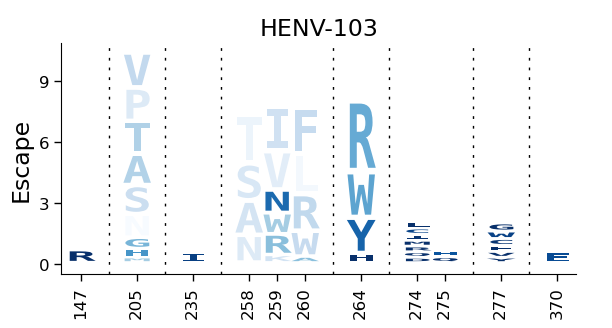

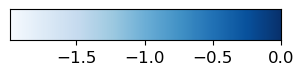

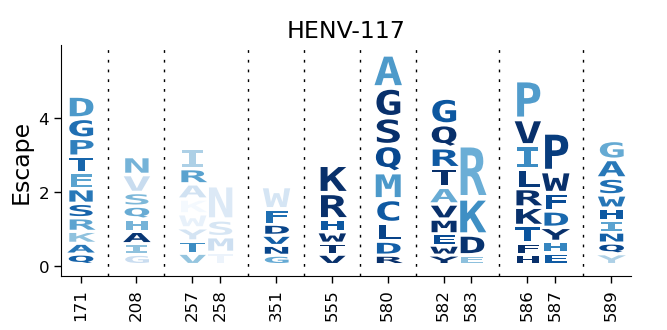

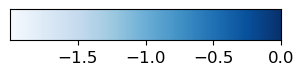

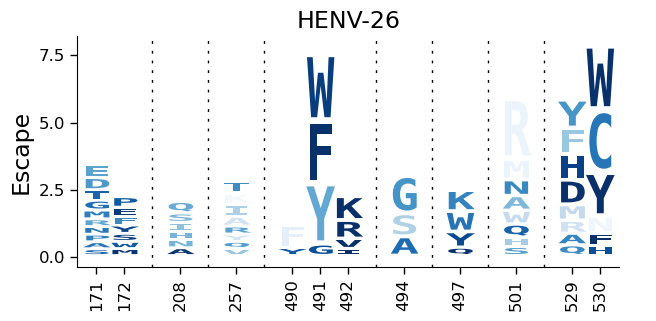

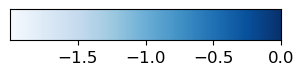

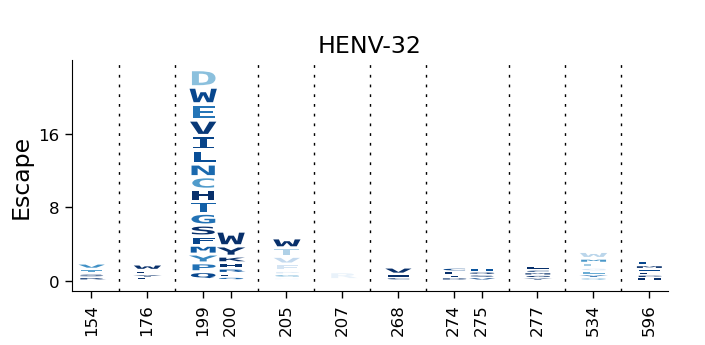

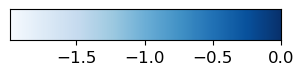

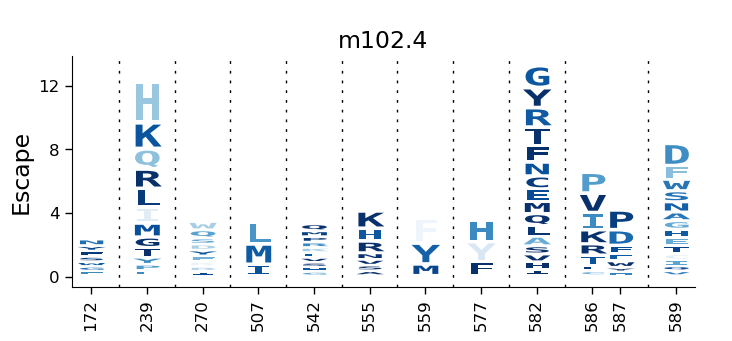

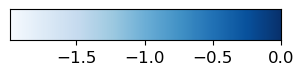

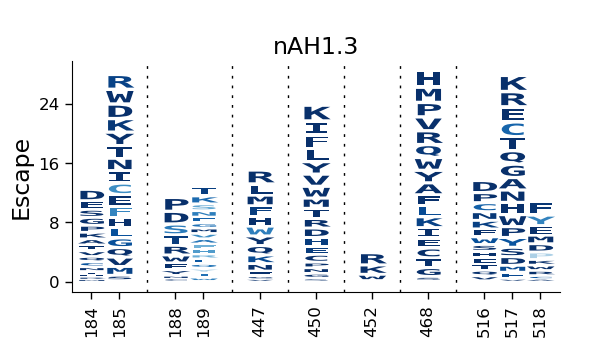

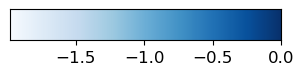

In [7]:
func_scores = pd.read_csv('../Nipah_Malaysia_RBP_DMS/results/func_effects/averages/CHO_EFNB3_low_func_effects.csv')

def generate_logo_plot(df, output_file, title):
    """Generate logo plot and save as a file."""
    fig, ax = dmslogo.draw_logo(
        data=df.query('show_site'),
        x_col='site',
        letter_col='mutant',
        letter_height_col='escape_mean',
        ylabel='Escape',
        xlabel='',
        color_col='color',
        title=title
    )
    fig.savefig(output_file, bbox_inches='tight',format='svg')

dfs_filter_only = {}
def prepare_mab_escape_for_logo(df,name,filtered_output,logo_output):
    tmp_df = df.merge(func_scores, on=['site','wildtype','mutant'],how='left',suffixes=['_ab','_func_effects'])
    #filter
    tmp_df = tmp_df[
        (tmp_df['site'] != 603) &
        (tmp_df['mutant'] != '*') &
        (tmp_df['mutant'] != '-') &
        (tmp_df['times_seen_func_effects'] >= config['func_times_seen_cutoff']) &
        (tmp_df['times_seen_ab'] >= config['min_times_seen_ab']) &
        (tmp_df['frac_models'] >= config['frac_models']) &
        (tmp_df['effect'] >= config['min_func_effect_for_ab']) &
        (tmp_df['escape_std'] <= config['max_ab_std']) 
    ]
    
    # Get sites with max score over some percentile threshold
    sums_max = tmp_df.groupby('site')['escape_mean'].max()
    quantile_max = sums_max.quantile(config['max_quantile'])
    sites_max_score = sums_max[sums_max > quantile_max].index.tolist()
    display(sites_max_score)
    # Get sites with sum score over percentile threshold
    sums_total = tmp_df.groupby('site')['escape_mean'].sum()
    quantile_total = sums_total.quantile(config['sum_quantile'])
    sites_agg_sum = sums_total[sums_total > quantile_total].index.tolist()
    
    # Combine both lists of sites
    sites_to_show_list = list(set(sites_max_score + sites_agg_sum))
    # Add a column to data
    tmp_df['show_site'] = tmp_df['site'].isin(sites_to_show_list)
    tmp_df['ab'] = name
    # Save processed df of each mAb for mapping onto crystal structure
    tmp_df.to_csv(filtered_output, index=False)

    # Remove small escape sites
    tmp_df = tmp_df[tmp_df['escape_mean'] >= config['min_escape_cutoff']]

    # Color by functional score and clip scores > 0
    tmp_df['clip'] = np.clip(tmp_df['effect'], None, 0)
    min_prop = tmp_df['effect'].min()
    max_prop = tmp_df['clip'].max()

    map1 = ValueToColorMap(minvalue=min_prop, maxvalue=max_prop, cmap='Blues')
    tmp_df['color'] = tmp_df['clip'].map(map1.val_to_color)
    generate_logo_plot(tmp_df, logo_output, name)
    tmp_df = tmp_df[['site','wildtype','mutant','mutation','escape_mean','escape_std','times_seen_ab','effect','show_site']]
    
    fig, _ = map1.scale_bar(orientation='horizontal')
    fig.savefig('results/images/logo_plots/scalebar.svg', bbox_inches='tight',format='svg')
    
    return tmp_df

HENV103_df = prepare_mab_escape_for_logo(HENV103,'HENV-103', HENV103_filtered_path, HENV103_logo_path)
HENV117_df = prepare_mab_escape_for_logo(HENV117,'HENV-117', HENV117_filtered_path, HENV117_logo_path)
HENV26_df = prepare_mab_escape_for_logo(HENV26,'HENV-26', HENV26_filtered_path, HENV26_logo_path)
HENV32_df = prepare_mab_escape_for_logo(HENV32,'HENV-32', HENV32_filtered_path, HENV32_logo_path)
m102_df = prepare_mab_escape_for_logo(m102,'m102.4', m102_filtered_path, m102_logo_path)
nAH1_df = prepare_mab_escape_for_logo(nAH1,'nAH1.3', nAH1_filtered_path, nAH1_logo_path)